In [219]:
# %%writefile Ind_RSRS.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
# import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class MOM(Ind_Model_Base.Ind_Model):
    """动量线（MOM）"""
    optimum_param={'valid':True, 'main':'feature_MOM_CONTINUITY_NEG_ABS', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'MOM', frequence)
        self.renko_objs={}
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'short':5, 'long':20}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """试验结果：信号持续性越接近“中间（0？）”越好，多周期基本相同
        """
        def feature(item_df):
            direct = np.sign(item_df['mom_1'] - item_df['mom_2'])
            return -1 * np.abs( af.timeline_event_continuity(direct.fillna(0)) )
        
        event_continuity = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(feature(x),
                                         index=x.index,
                                         columns=['feature_MOM_CONTINUITY_NEG_ABS']))
        self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return event_continuity
        
    def kernel(self,dataframe, short, long):
        mom_a =talib.MOM(dataframe.close, timeperiod=short)
        mom_b =talib.MOM(dataframe.close, timeperiod=long)

        df = pd.concat([mom_a, mom_b], axis=1)
        df.columns=['mom_1','mom_2']

        return df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


Wall time: 92 ms


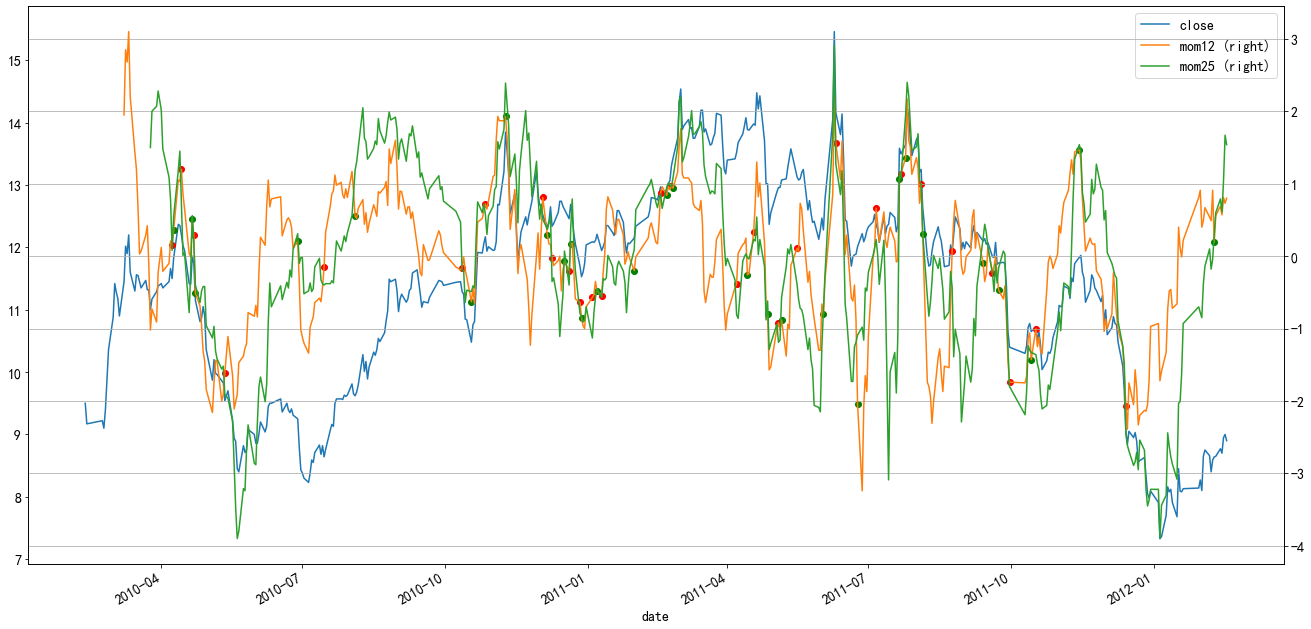

In [201]:
%%time
# import sys
# import os 
# module_path = os.path.abspath(os.path.join('..')) 
# if module_path not in sys.path: 
#     sys.path.append(module_path)
# import tools.Sample_Tools as smpl
# import Analysis_Funs as af
# import base.JuUnits as ju
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import talib
# data = smpl.get_data(['000004'],start='2010-01-15',gap=504).data

dd= data.reset_index('code',drop=True)
mom12 =talib.MOM(dd.close, timeperiod=12)
mom25 =talib.MOM(dd.close, timeperiod=25)

a = pd.concat([mom12, mom25], axis=1)
a.columns=['mom12','mom25']
# a=a.rolling(6).mean()
pd.concat([dd['close'],a],axis=1).plot(secondary_y=['mom12','mom25'],figsize=(1620/72,820/72))
plt.grid()
up_event = pd.Series(np.where(a['mom12'] > a['mom25'], 1, 0),index=a['mom12'].index)
down_event = pd.Series(np.where(a['mom12'] < a['mom25'], -1, 0),index=a['mom12'].index)
jcsc = up_event.diff().fillna(0)
# plt.scatter()
jc = jcsc[jcsc>0]
sc = jcsc[jcsc<0]
plt.scatter(jc.index.values,a['mom12'].loc[jc.index], color='r')
plt.scatter(sc.index.values,a['mom12'].loc[sc.index], color='g')

direct = np.sign(a['mom12']-a['mom25'])
# af.feature_JXSX_timeline(direct)
# direct.values

# af.timeline_event_continuity(direct.fillna(0))
# np.diff(np.where(mom12 > mom25, 1, 0))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


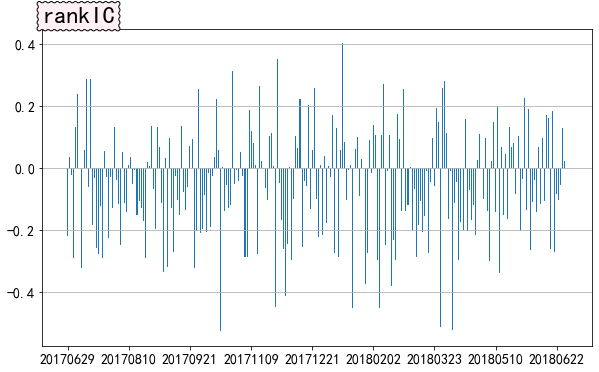

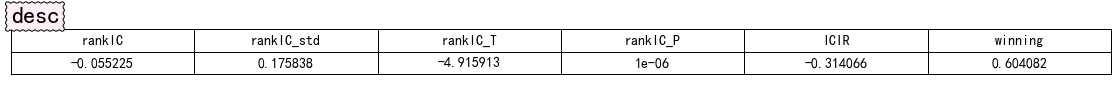

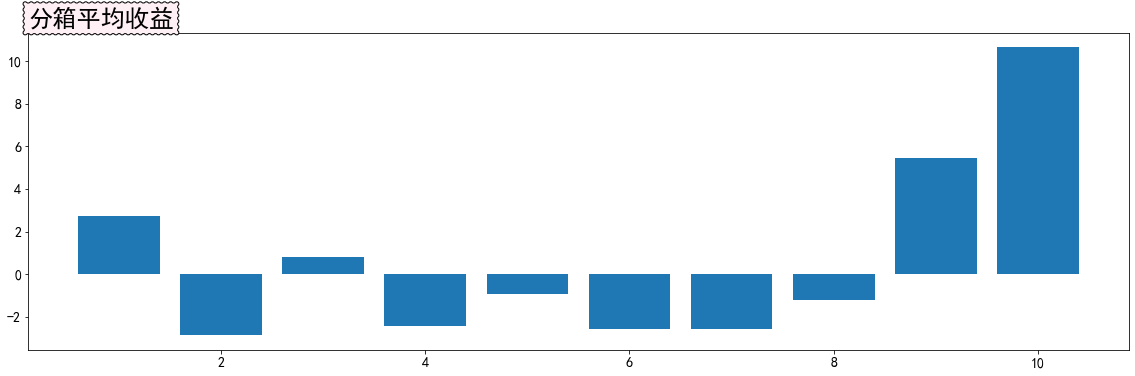

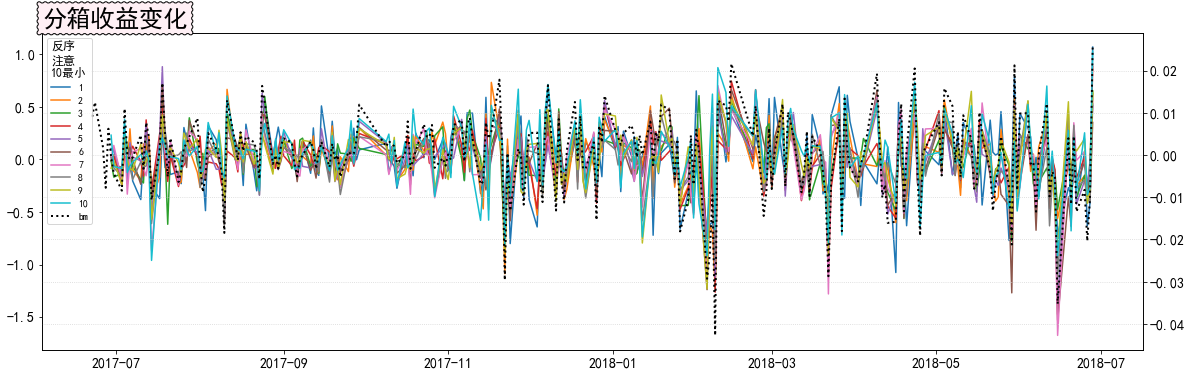

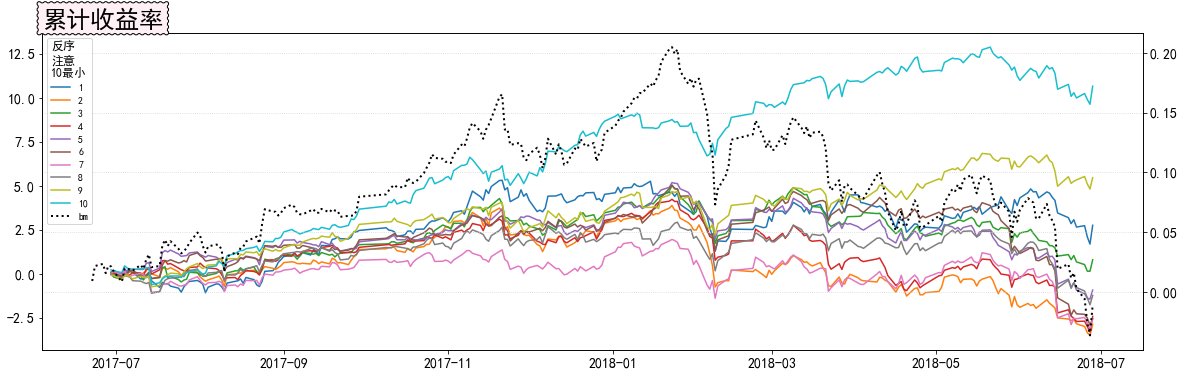

Wall time: 12.9 s


In [189]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

test = FactorTest(MOM, sample='沪深300', freq="d",end='2018-06-29',gap=250,only_main=True,neutralize={'enable':False,'static_mv':False},target_field='mom_1')
test.process()
test.plot()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


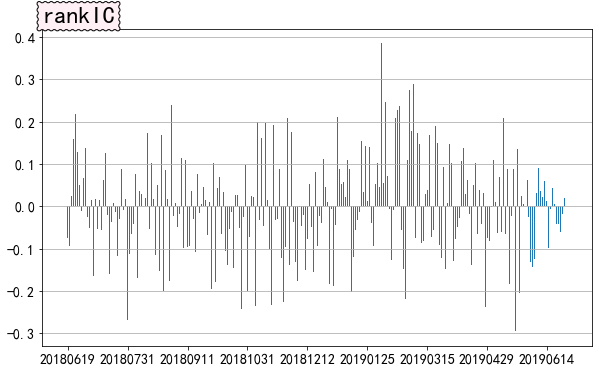

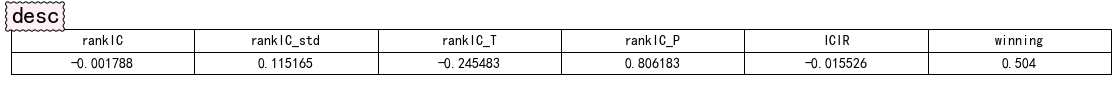

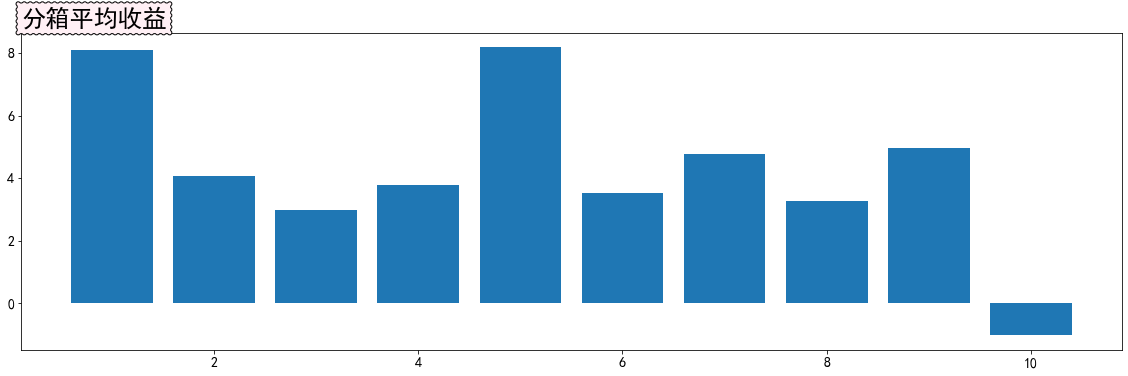

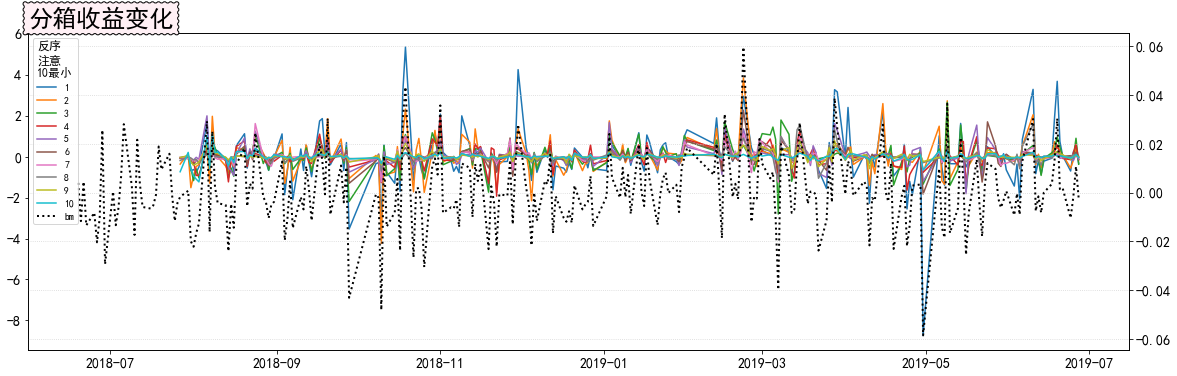

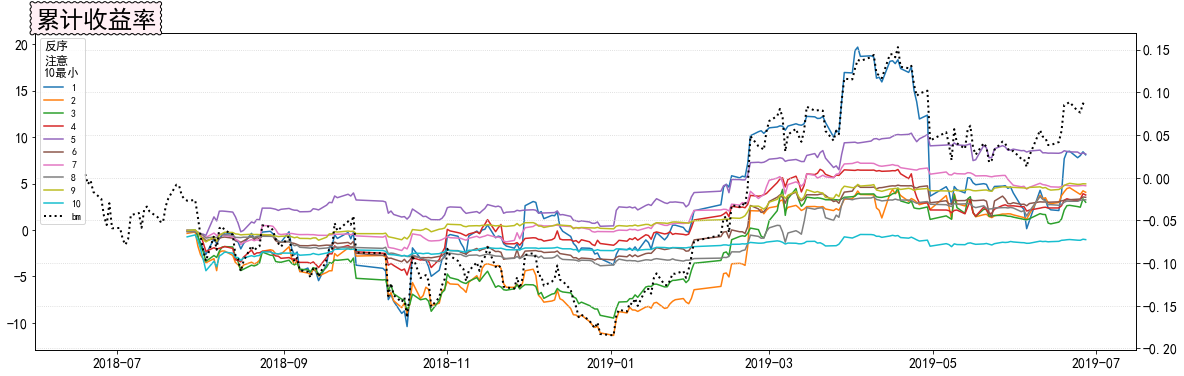

Wall time: 13.2 s


In [222]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

test = FactorTest(MOM, sample='沪深300', freq="d",end='2019-06-29',gap=250,only_main=True,neutralize={'enable':False,'static_mv':False},target_field='feature_MOM_CONTINUITY_NEG_ABS')
test.process()
test.plot()